
# 03.2 Otros métodos de agrupación - Clustering Jerárquico y Densidad


In [7]:
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
import numpy as np
from skimage import io
from IPython import display

## En este cuaderno vamos a necesitar dibujar un dendograma

Disponible en el "__03.0ClusteringUtilidades.ipynb__"

In [8]:
%run 03-0_ClusteringUtilidades.ipynb

load done!


## Descripción general del método de agrupación jerárquica

- A diferencia de __K-means__, son métodos __deterministas__.
- Parten de una matriz $D = (d_{ij})$ de __distancias__ o $S = (s_{ij})$ de __similitudes__, matrices $N \times N$ entre los $N$ elementos del conjunto de instancias.
- Si todas las variables son __continuas__, la distancia más utilizada es la euclídea (con variables estandarizadas univariantemente en caso de ser conveniente).
- Si hay variables __continuas__ y __categóricas__ no suele ser aceptable trabajar con distancias y se usan __similitudes__.

El algoritmo tiene los siguientes pasos:

- Comenzamos con __N grupos__ (uno para cada instancia) y la matriz _D_ o _S_.
- Buscamos los elementos más __próximos__ (mínimo valor $d_{ij}$ o $s_{ij}$) y los unimos en un grupo.
- Recalculamos la matriz de distancias (o similitudes) definiendo una __distancia o similitud entre este nuevo grupo__ y el resto.
- Repetimos los dos pasos anteriores hasta que todas las observaciones estén unidas en un solo grupo

La forma de calcular la distancia entre grupos de puntos puede hacerse de diferentes formas como:
- Por __encadenamiento simple__ tomando como distancia de 2 grupos la de los 2 puntos más próximos. Tiende a __encadenar individuos sueltos__ y no grupos.
- Por __encadenamiento completo__ tomando como distancia de 2 grupos la de los 2 puntos más alejados. Es menos sensible a __atípicos__.
- Método de __Ward__ que __maximiza la homogeneidad__ intra-grupo. Como medida de homogeneidad se usa la __suma de cuadrados__ de los errores. Tiende a formar grupos esféricos aunque los grupos no lo sean.

Una forma de visualizar la estructura del grupo gerárquico es con el __dendograma__.

<img src="images/clusterJerarq.png" width="500px">

### Ejemplo simple de una agrupación jerárquica

Un ejemplo simple del __proceso de agrupación jerárquica__ donde se utiliza la __distancia euclídea__ para calcular la matriz de distancias se muestra a continuación.

En cada paso se forma un nuevo grupo que implica el __recálculo de las coordenadas de su centroide (en verde)__.


<img src="images/Proceso_Jerarquico.png" width="700px">

### Dendograma con el resultado del ejemplo

Se muestran las posibles soluciones en función del nivel de agrupación


<img src="images/Dendograma.png" width="700px">

### Caso de uso de la similitud

En el caso de usar una similitud el algoritmo sería igual pero sustituyendo la matriz de distancia por una de similitud. La diagonal principal serían _unos_ y el cálculo de las similitudes entre dos elementos sería como se indica en el ejemplo que aparece a continuación.


## Cluster jerárquico sobre el conjunto Iris

In [9]:
from sklearn.datasets import load_iris
import pandas as pd
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target']=iris['target']
df.head()
X = df.values[:,0:4]
y = df.values[:,4]

Se resuelve un cluster aglomerativo con __scikit-learn__ que es __AgglomerativeClustering__, cuyos parámetros más importantes son:

- __n_clusters__ (int o None, default=2). El número de clústeres a buscar. Debe ser None si distance_threshold no es None.
- __affinity__ (str o función llamable, default=’euclidean’). Métrica utilizada. Puede ser "euclidian", "l1", "l2", "manhattan", "cosine" o "precomputed". Si la linkage es “ward”, solo se acepta “euclidean”. Si es "precomputed", se necesita una matriz de distancia (en lugar de una matriz de similitud) como entrada para el método de ajuste.
- __compute_full_tree__ (‘auto’ or bool, default=’auto’). Para la ejecución hasta construir n_clusters.
- __linkage__ (‘ward’, ‘complete’, ‘average’, ‘single’, default=’ward’). 
- __distance_threshold__ (float, default=None), es el umbral de distancia de vinculación por encima del cual los clústeres no se fusionarán. Si no es None, n_clusters debe ser None y compute_full_tree debe ser True.
- __compute_distances__ (bool, default=False). Calcula las distancias entre los clústeres incluso si no se utiliza la distancia umbral (distance_threshold). Sirve para hacer la visualización de dendrogramas, pero introduce una sobrecarga computacional y de memoria. (Nuevo en versión 0.24)

__Según los valores de linkage__:
- 'ward' __minimiza la varianza__ de los grupos que se fusionan.
- ‘average’ usa el __promedio de las distancias__ de cada observación de los dos conjuntos.
- 'complete' utiliza __las distancias máximas__ entre todas las observaciones de los dos conjuntos.
- 'single' utiliza el __mínimo de las distancias__ entre todas las observaciones de los dos conjuntos.

In [10]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
y_ag = ac.fit_predict(X)
etiquetas=np.unique(y_ag) 

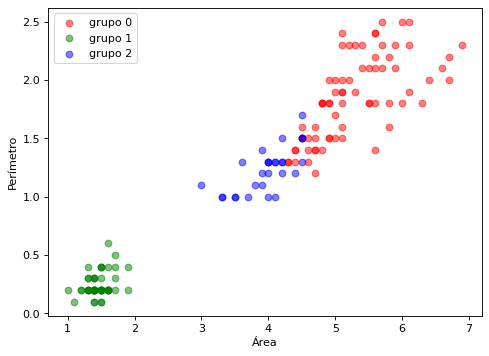

In [11]:
import matplotlib.pyplot as plt
names = ['grupo 0', 'grupo 1', 'grupo 2']
marcas = ['*', 'o', 's']
color = ['red', 'green', 'blue']
plt.figure(figsize=(7, 5), dpi=80)
for i in range(len(names)):
    cl = i
    plt.scatter(X[y_ag==cl,2], X[y_ag==cl,3], c=color[i], alpha=0.5, marker='o', label=names[i])
plt.xlabel("Área")
plt.ylabel("Perímetro")
plt.legend(loc='upper left')
plt.show()

### Es posible visualizar el dendograma con la siguiente ejecución

- Para que se pueda dibujar el dendograma es necesario que <b>AgglomerativeClustering</b> construya la variable <b>distances_</b>. Hay que dar una combinación de parámetros que lo permita.

Las variables que maneja el cluster jerarquico y que intervienen en la construcción del dendograma tienen la siguiente estructura:
- <b>distances_</b> : Es una lista con las distancias a las que se han ido efectuando las uniones por orden de aparición en el dendograma. Ocurren de menor distancia a mayor distancia. En el dendograma la escala de las distancias aparece en el eje vertical. 
- <b>children_</b> : Es una lista con los pares de elementos que se funden en cada nodo del dendograma. Por cada item de distancia aparece un item con el nodo. El número de filas del conjunto X se corresponde con el nº de elementos de devuelve fit_predict y que se vuelcan en __etiquetas__, supongamos __N__. Cuando en el nodo se unen dos elementos individuales en  <b>children_</b> aparecen dos números entre __0 y N-1__, pero si unen nodos de agrupaciones anteriores a aperecen valores __N o mayor que N__. 

In [12]:
cluster_dist = AgglomerativeClustering(distance_threshold=None, n_clusters=3, compute_distances=True)
cluster_dist.fit(X)

AgglomerativeClustering(compute_distances=True, n_clusters=3)

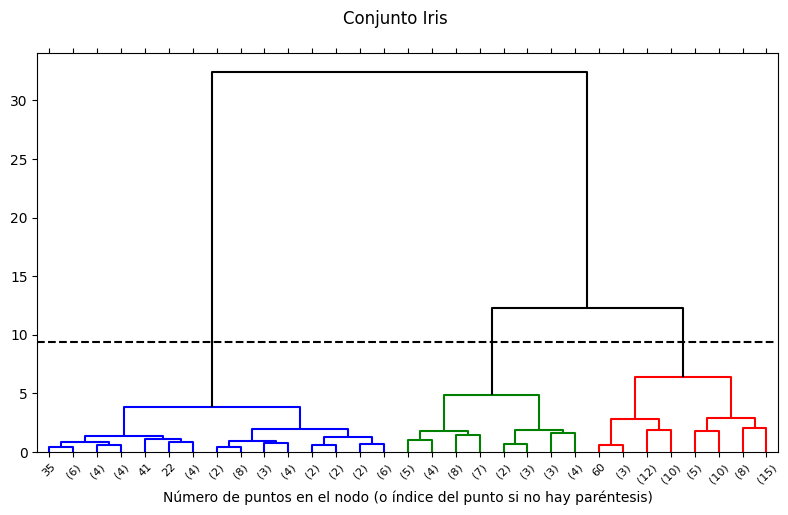

In [13]:
titulo="Conjunto Iris"
subtitulo="Número de puntos en el nodo (o índice del punto si no hay paréntesis)"
figSize=(8,5)
plot_dendrogram(cluster_dist, titulo, subtitulo, figSize, truncate_mode='level', p=4)


__El encadenamiento simple__: tiende a __encadenar individuos sueltos__ y no grupos.

<img src="images/jerarquico_single.png" width="500px">

__El encadenamiento completo__: es menos sensible a __atípicos__.

<img src="images/jerarquico_complete.png" width="500px">

__Ward__ tiende a __formar grupos esféricos__ aunque los grupos no lo sean

<img src="images/jerarquico_ward.png" width="500px">

## Clustering por densidad. DBSCAN

Un cuarto modo de clustering, también determinístico, es el __Density-Based Spatial Clustering of Applications with Noise (DBSCAN)__. Agrupa áreas de alta densidad quitando los puntos atípicos o outliers. Cada grupo se forma por la unión de puntos centrales R-vecinos junto con sus puntos frontera. Los puntos outliers se descartan. La densidad se basa en R, el radio de vecindad y M, mínimo número de vecinos para definir un cluster. Un punto se denomina central si dentro de su R-vecindad hay al menos M puntos. Un punto se denomina frontera si está en la R-vecindad de un central, pero no tiene M R-vecinos. Un punto atípico o outlier es aquel que ni es central, ni frontera. 

<img src="images/dbscan.png" width="400px">

In [15]:
from sklearn.cluster import DBSCAN 
db = DBSCAN(eps=0.5, min_samples=10, metric='euclidean')
#db = DBSCAN(eps=1, min_samples=40, metric='euclidean')
y_db = db.fit_predict(X)
np.unique(y_db)

array([-1,  0,  1], dtype=int64)

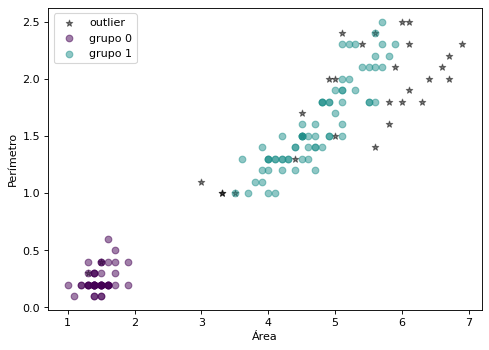

In [16]:
import matplotlib.pyplot as plt
from matplotlib import cm
viridis = cm.get_cmap('viridis', len(np.unique(y_db)))
plt.figure(figsize=(7, 5), dpi=80)
for i in np.unique(y_db):
    cl = i
    etiqueta="grupo " + str(i)
    if cl==-1:
        plt.scatter(X[y_db==cl,2], X[y_db==cl,3], c="k", alpha=0.5, marker='*', label="outlier")
    else:
        plt.scatter(X[y_db==cl,2], X[y_db==cl,3], color=viridis(i), alpha=0.5, marker='o', label=etiqueta)
plt.xlabel("Área")
plt.ylabel("Perímetro")
plt.legend(loc='upper left')
plt.show()